<h1 align="center">Predicting Video Game Sales</h1>
<h3 align="center">With a Residual Modeling Ensemble</h3>
<p align="center"><em>$R^2 = 0.8040$ | CatBoost + XGBoost Pipeline</em></p>
<p align="center">
  <a href="https://github.com/Toshiim">GitHub</a> •
  <a href="https://www.kaggle.com/gpugobrrr">Kaggle</a>
</p>

---

## _Introduction_
---

This notebook explores predicting global video game sales using an ensemble approach.

The dataset contains game characteristics like genre, platform, publisher, developer, year of release and critic/user ratings.

Approach: Train CatBoost as base model, then use XGBoost to predict and correct the residuals. Final R² = 0.8040 on test set.

In [57]:
import kagglehub
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import copy
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from functools import partial
from sklearn.ensemble import ExtraTreesRegressor
from scipy.optimize import minimize_scalar

from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_parallel_coordinate


In [58]:
path = kagglehub.dataset_download("rush4ratio/video-game-sales-with-ratings")

print(path)

C:\Users\T\.cache\kagglehub\datasets\rush4ratio\video-game-sales-with-ratings\versions\2


In [59]:
try:
    df = pd.read_csv(path + "\\Video_Games_Sales_as_at_22_Dec_2016.csv")
    print(df.head())
except Exception as e:
    print(e)

                       Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii           2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES           1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii           2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii           2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0   
4     11.27      8.89     10.22         1.00         31.37           NaN   

   Critic_Count User_Score  User_Count Developer Rating 

## *Data Validation & Preparing*
---

In [60]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


In [61]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [62]:
df = df.dropna()
print(f"Strings: {df.shape[0]}")

Strings: 6825


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6825 non-null   object 
 1   Platform         6825 non-null   object 
 2   Year_of_Release  6825 non-null   float64
 3   Genre            6825 non-null   object 
 4   Publisher        6825 non-null   object 
 5   NA_Sales         6825 non-null   float64
 6   EU_Sales         6825 non-null   float64
 7   JP_Sales         6825 non-null   float64
 8   Other_Sales      6825 non-null   float64
 9   Global_Sales     6825 non-null   float64
 10  Critic_Score     6825 non-null   float64
 11  Critic_Count     6825 non-null   float64
 12  User_Score       6825 non-null   object 
 13  User_Count       6825 non-null   float64
 14  Developer        6825 non-null   object 
 15  Rating           6825 non-null   object 
dtypes: float64(9), object(7)
memory usage: 906.4+ KB


 Checking for data inconsistency, when NA_sales + EU_sales + JP_sales + Other_sales != Global_sales

In [64]:
regional_sum = df["NA_Sales"] + df["EU_Sales"] + df["JP_Sales"] + df["Other_Sales"]

MAE = (regional_sum - df["Global_Sales"]).abs().mean()
MaxE = (regional_sum - df["Global_Sales"]).abs().max()
relative_error = ((regional_sum - df["Global_Sales"]) / df["Global_Sales"]).abs()

print(f"MAE:  {MAE:.4f}")
print(f"MaxE: {MaxE:.4f}")
print(f"Relative mean error: {relative_error.mean():.2%}")

max_relative_error = relative_error.max()
print(f"Max relative error: {max_relative_error:.2%}")

MAE:  0.0035
MaxE: 0.0200
Relative mean error: 2.56%
Max relative error: 100.00%



On average, the error is insignificant, but there is invalid data. Let's clear it

In [65]:
threshold = 0.20
mask = relative_error <= threshold

df_filtered = df[mask]

regional_sum_filtered = df_filtered["NA_Sales"] + df_filtered["EU_Sales"] + df_filtered["JP_Sales"] + df_filtered["Other_Sales"]
relative_error_filtered = ((regional_sum_filtered - df_filtered["Global_Sales"]) / df_filtered["Global_Sales"]).abs()

print(f"Filtered: {len(df) - len(df_filtered)} outliers")
print(f"New relative error: {relative_error_filtered.mean():.2%}")


Filtred: 259 outliers
New relative error: 1.33%


In [66]:
df_filtered.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,6566.000000,6566.000000,6566.000000,6566.000000,6566.000000,6566.000000,6566.000000,6566.000000,6566.000000
mean,2007.440299,0.409499,0.244913,0.066668,0.085864,0.806936,70.468931,29.283734,178.259823
std,4.205283,0.983263,0.699288,0.292903,0.274655,1.996120,13.790264,19.354214,597.342533
min,1988.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2004.000000,0.070000,0.020000,0.000000,0.010000,0.130000,62.000000,14.000000,11.000000
50%,2007.000000,0.160000,0.070000,0.000000,0.020000,0.320000,73.000000,25.000000,27.000000
75%,2011.000000,0.410000,0.220000,0.020000,0.070000,0.790000,81.000000,40.000000,89.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,10665.000000


In [67]:
df_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6566 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6566 non-null   object 
 1   Platform         6566 non-null   object 
 2   Year_of_Release  6566 non-null   float64
 3   Genre            6566 non-null   object 
 4   Publisher        6566 non-null   object 
 5   NA_Sales         6566 non-null   float64
 6   EU_Sales         6566 non-null   float64
 7   JP_Sales         6566 non-null   float64
 8   Other_Sales      6566 non-null   float64
 9   Global_Sales     6566 non-null   float64
 10  Critic_Score     6566 non-null   float64
 11  Critic_Count     6566 non-null   float64
 12  User_Score       6566 non-null   object 
 13  User_Count       6566 non-null   float64
 14  Developer        6566 non-null   object 
 15  Rating           6566 non-null   object 
dtypes: float64(9), object(7)
memory usage: 872.0+ KB


Perhaps, if User_Score object and not float64 it contains not only numbers

In [68]:
df_filtered["User_Score"].unique()

array(['8', '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4', '8.2',
       '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2', '8.9',
       '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3', '7.6',
       '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1', '6.7',
       '5.4', '4', '9.3', '6.2', '4.2', '6', '4.9', '3.7', '4.1', '5.8',
       '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1', '2.9', '5.2',
       '3.3', '4.5', '5.1', '3.5', '2.5', '1.9', '2.2', '2', '9.5', '4.7',
       '2.1', '3.6', '1.8', '3.8', '3', '9.6', '2.8', '1.7', '2.7', '2.4',
       '1.5', '1.2', '2.3', '0.5', '0.6', '0.9', '1', '1.4', '1.3'],
      dtype=object)

In [69]:
df_filtered = df_filtered.copy()
df_filtered["User_Score"] = pd.to_numeric(df_filtered["User_Score"])
df_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6566 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6566 non-null   object 
 1   Platform         6566 non-null   object 
 2   Year_of_Release  6566 non-null   float64
 3   Genre            6566 non-null   object 
 4   Publisher        6566 non-null   object 
 5   NA_Sales         6566 non-null   float64
 6   EU_Sales         6566 non-null   float64
 7   JP_Sales         6566 non-null   float64
 8   Other_Sales      6566 non-null   float64
 9   Global_Sales     6566 non-null   float64
 10  Critic_Score     6566 non-null   float64
 11  Critic_Count     6566 non-null   float64
 12  User_Score       6566 non-null   float64
 13  User_Count       6566 non-null   float64
 14  Developer        6566 non-null   object 
 15  Rating           6566 non-null   object 
dtypes: float64(10), object(6)
memory usage: 872.0+ KB


## *Machine learning pipeline*
---

### Analytics

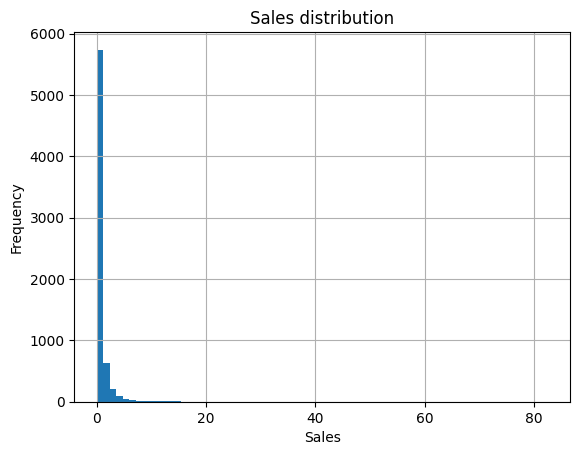

In [70]:
plt.hist(abs(df["Global_Sales"]), bins=70)
plt.grid(True)
plt.title("Sales distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

Target value extremely positively skewed. I'll try to log it.

In [71]:
log_sales = np.log1p(df["Global_Sales"])

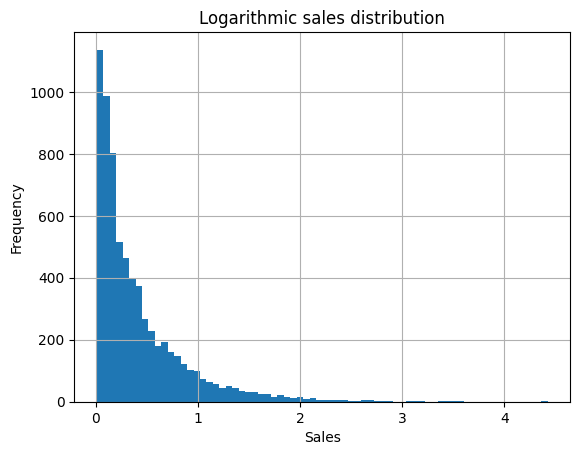

In [72]:
plt.hist(abs(log_sales), bins=70)
plt.grid(True)
plt.title("Logarithmic sales distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

Much better. I will use log target for training and delog result for prediction.

In [73]:
df_filtered = df_filtered.drop(columns=["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"])
df_filtered.corr(numeric_only = True)["Global_Sales"].sort_values(ascending = False)

Global_Sales       1.000000
Critic_Count       0.287863
User_Count         0.263306
Critic_Score       0.238750
User_Score         0.087351
Year_of_Release    0.006468
Name: Global_Sales, dtype: float64

Linear correlations with target are quite low

### Stratification & Spliting

In [74]:
# Stratification should come before feature extracting to prevent data leakage.
y = df_filtered["Global_Sales"]

quantiles = pd.qcut(y, q=6, labels=False, duplicates='drop')

df_train, df_temp = train_test_split(
    df_filtered,
    test_size=0.4,
    stratify=quantiles,
    random_state=42
)
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=quantiles.loc[df_temp.index],
    random_state=42
)

full_df = [df_train, df_val, df_test]

In [75]:
for name, df in zip(["Train", "Validation", "Test"], [df_train, df_val, df_test]):
    print(f"{name}:")
    print(df["Global_Sales"].describe())
    print()


Train:
count    3939.000000
mean        0.823826
std         2.183565
min         0.010000
25%         0.130000
50%         0.320000
75%         0.790000
max        82.530000
Name: Global_Sales, dtype: float64

Validation:
count    1313.000000
mean        0.736093
std         1.267106
min         0.010000
25%         0.120000
50%         0.310000
75%         0.790000
max        13.470000
Name: Global_Sales, dtype: float64

Test:
count    1314.000000
mean        0.827093
std         2.002903
min         0.010000
25%         0.130000
50%         0.310000
75%         0.780000
max        29.800000
Name: Global_Sales, dtype: float64



### Feature Engineering

In [76]:
publisher_counts = df_train["Publisher"].value_counts()
publisher_counts.sort_values(ascending = False).head(15)

Publisher
Electronic Arts                           558
Activision                                303
Ubisoft                                   266
Sony Computer Entertainment               194
Nintendo                                  172
THQ                                       167
Take-Two Interactive                      163
Sega                                      161
Namco Bandai Games                        139
Konami Digital Entertainment              138
Capcom                                    104
Atari                                     103
Tecmo Koei                                 82
Warner Bros. Interactive Entertainment     81
Microsoft Game Studios                     80
Name: count, dtype: int64

In [77]:
developer_counts = df_train["Developer"].value_counts()
developer_counts.sort_values(ascending = False).head(15)

Developer
EA Sports            88
EA Canada            87
Ubisoft              64
Capcom               62
Konami               47
Ubisoft Montreal     44
EA Tiburon           43
Electronic Arts      41
Nintendo             41
Visual Concepts      41
Codemasters          38
Omega Force          35
Namco                35
Vicarious Visions    34
Traveller's Tales    33
Name: count, dtype: int64

In [78]:
for df in full_df:
    df["Publisher_Release_Count"] = df["Publisher"].map(publisher_counts)
    df["Developer_Release_Count"] = df["Developer"].map(developer_counts)

In [79]:
# To prevent data leakage I compute frequency features with only train split, and join it for all other splits.
# However, some categories from validation/test splits are not present in train split,
# which creates ~5% NaN values when mapping frequency features.
# This data adds noise to models testing, and shows generalization capabilities, for unexpected data outside of training.
# Metrics obtained in this way potentially better represent model's perfromance in production.

# For ensemble learning experiments, I'm keeping both approaches:
# - Clean version (NaN removal) shows maximum potential of algorithms
# - Realistic version (NaN filling) tests robustness to missing category information


# Uncomment lines below if you want better metrics
# And comment if you're an honest person and want to represent real model's generalization

# P.S. I'm not so honest

split_names = ["train", "val", "test"]
original_counts = [df.shape[0] for df in full_df]

full_df = [df.dropna() for df in full_df]

filtered_counts = [df.shape[0] for df in full_df]
for name, before, after in zip(split_names, original_counts, filtered_counts):
    print(f"{name.capitalize():<6}: removed {before - after} rows (from {before} to {after})")

total_removed = sum(original_counts) - sum(filtered_counts)
print(f"\nTotal removed: {total_removed} rows")

Train : removed 0 rows (from 3939 to 3939)
Val   : removed 173 rows (from 1313 to 1140)
Test  : removed 174 rows (from 1314 to 1140)

Total removed: 347 rows


In [80]:
df_train["Mean_Score"] = df_train[["User_Score", "Critic_Score"]].mean(axis=1)
developer_score = df_train.groupby("Developer")["Mean_Score"].mean().rename("Developer_Mean_Score")
publisher_score = df_train.groupby("Publisher")["Mean_Score"].mean().rename("Publisher_Mean_Score")
platform_user_count = df_train.groupby("Platform")["User_Count"].mean().rename("Platform_User_Count")

full_df_advanced = copy.deepcopy(full_df)
for i in range(len(full_df)):
    df = full_df[i].copy()
    df["Mean_Score"] = df[["User_Score", "Critic_Score"]].mean(axis=1)
    df = df.join(developer_score, on="Developer")
    df = df.join(publisher_score, on="Publisher")
    df = df.join(platform_user_count, on="Platform")
    full_df_advanced[i] = df

In [81]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3939 entries, 3530 to 1088
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     3939 non-null   object 
 1   Platform                 3939 non-null   object 
 2   Year_of_Release          3939 non-null   float64
 3   Genre                    3939 non-null   object 
 4   Publisher                3939 non-null   object 
 5   Global_Sales             3939 non-null   float64
 6   Critic_Score             3939 non-null   float64
 7   Critic_Count             3939 non-null   float64
 8   User_Score               3939 non-null   float64
 9   User_Count               3939 non-null   float64
 10  Developer                3939 non-null   object 
 11  Rating                   3939 non-null   object 
 12  Publisher_Release_Count  3939 non-null   int64  
 13  Developer_Release_Count  3939 non-null   int64  
 14  Mean_Score               3

### Building bagging ensemble.

In [82]:
def train(
    original_df,
    get_metrics = False,
    **kwargs
):
    df_full = copy.deepcopy(original_df)
    for df in df_full[:2]:
        df["Global_Sales"] = np.log1p(df["Global_Sales"])

    df_train_model = df_full[0]
    df_val_model = df_full[1]
    df_test_model = df_full[2]


    X_train = df_train_model.drop(columns=["Name", "Global_Sales"])
    y_train = df_train_model["Global_Sales"]

    X_val = df_val_model.drop(columns=["Name", "Global_Sales"])
    y_val = df_val_model["Global_Sales"]

    X_test = df_test_model.drop(columns=["Name", "Global_Sales"])
    y_test = df_test_model["Global_Sales"]

    cat_features = X_train.select_dtypes(include = object).columns.tolist()

    print(f"Train: {len(X_train)} strings ({len(X_train)/len(df_filtered)*100:.1f}%)")
    print(f"Validation: {len(X_val)} strings ({len(X_val)/len(df_filtered)*100:.1f}%)")
    print(f"Test: {len(X_test)} strings ({len(X_test)/len(df_filtered)*100:.1f}%)")
    print()

    model = CatBoostRegressor(
        cat_features=cat_features,
        use_best_model=True,
        verbose=500,
        random_state=42,
        **kwargs
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    raw_y_pred_train = model.predict(X_test)
    y_pred_train = np.expm1(raw_y_pred_train)

    r2 = r2_score(y_test, y_pred_train)
    mse = mean_squared_error(y_test, y_pred_train)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_train)
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    plt.hist(abs(y_pred_train - y_test), bins=70)
    plt.title("Absolute Error Distribution")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    feature_importance = model.get_feature_importance()
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
      'feature': feature_names,
      'importance': feature_importance
    }).sort_values('importance', ascending=False)


    print(f"\nMost important features:")
    print(importance_df.head(100))

    metrics = [r2,mse,rmse,mae]
    if get_metrics:
        return y_test, pd.Series(y_pred_train, name="y_pred_train"), copy.deepcopy(model), metrics
    else:
        return y_test, pd.Series(y_pred_train, name="y_pred_train"), copy.deepcopy(model)

Train: 3939 strings (60.0%)
Validation: 1140 strings (17.4%)
Test: 1140 strings (17.4%)

0:	learn: 0.4494222	test: 0.4279292	best: 0.4279292 (0)	total: 56.9ms	remaining: 4m 22s
500:	learn: 0.0891752	test: 0.2372744	best: 0.2372744 (500)	total: 44.9s	remaining: 6m 7s
1000:	learn: 0.0431958	test: 0.2369079	best: 0.2367097 (881)	total: 1m 26s	remaining: 5m 12s
Stopped by overfitting detector  (510 iterations wait)

bestTest = 0.2367096766
bestIteration = 881

Shrink model to first 882 iterations.
R²: 0.7402
MSE: 1.0642
RMSE: 1.0316
MAE: 0.3995


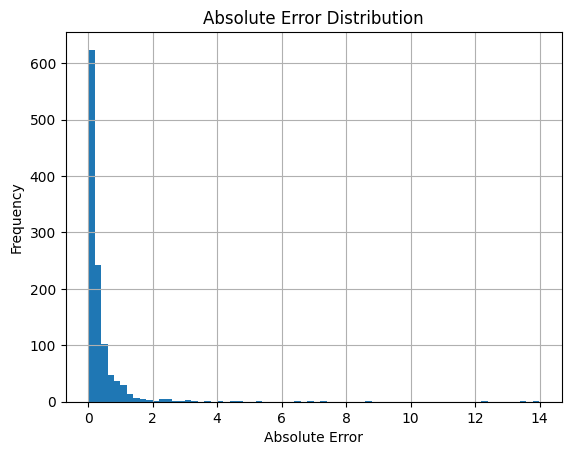


Most important feuteres:
                    feature  importance
7                User_Count   21.151124
0                  Platform    9.885824
15      Platform_User_Count    7.687903
2                     Genre    7.540046
1           Year_of_Release    7.342374
11  Developer_Release_Count    6.993047
9                    Rating    5.624176
10  Publisher_Release_Count    5.468361
3                 Publisher    5.051809
13     Developer_Mean_Score    3.977002
5              Critic_Count    3.730991
4              Critic_Score    3.618571
8                 Developer    3.118164
12               Mean_Score    3.075190
14     Publisher_Mean_Score    2.889154
6                User_Score    2.846266


In [83]:
y_testPS, y_predPS, main_model, main_model_metrics = train(full_df_advanced, iterations = 4606, early_stopping_rounds= int(4606*0.1+50), posterior_sampling=True, rsm = 0.812826754080271, task_type = "CPU", depth = 9, l2_leaf_reg =  1.0489107047302053, learning_rate = 0.06657010579964637, bagging_temperature = 0.07852150947288883,  random_strength = 0.036057785785986646, get_metrics = True) # See in unit "Hyperparameter optimization"

residPS = y_testPS - y_predPS

ensemble_resid_df = pd.DataFrame({'CatBoost_resid': residPS})

**Main model progress:**\
*With non-log target and OHP on posterior_sampling:*\
bestTest = 0.7681122589\
bestIteration = 912

R²: 0.6697\
MSE: 1.3240\
RMSE: 1.1506\
MAE: 0.4424

---
*With log target and OHP on posterior_sampling:*\
bestTest = 0.2337081974\
bestIteration = 3856

Shrink model to first 3857 iterations.\
R²: 0.6754\
MSE: 1.3011\
RMSE: 1.1406\
MAE: 0.3958

---
Cleared dataset from nan(Total removed: 347 rows):\
bestTest = 0.2367096766\
bestIteration = 881

Shrink model to first 882 iterations.\
R²: 0.7402\
MSE: 1.0642\
RMSE: 1.0316\
MAE: 0.3995


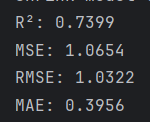

In [84]:
# I will try CatBoost regression mostly with categorial features
cat_model_df = []
for df in full_df_advanced:
    cat_model_df.append(df.drop(columns=["Developer_Release_Count", "Critic_Score",
                                       "Critic_Count", "User_Score", "User_Count",
                                       "Publisher_Release_Count"]))
cat_model_df[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3939 entries, 3530 to 1088
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  3939 non-null   object 
 1   Platform              3939 non-null   object 
 2   Year_of_Release       3939 non-null   float64
 3   Genre                 3939 non-null   object 
 4   Publisher             3939 non-null   object 
 5   Global_Sales          3939 non-null   float64
 6   Developer             3939 non-null   object 
 7   Rating                3939 non-null   object 
 8   Mean_Score            3939 non-null   float64
 9   Developer_Mean_Score  3939 non-null   float64
 10  Publisher_Mean_Score  3939 non-null   float64
 11  Platform_User_Count   3939 non-null   float64
dtypes: float64(6), object(6)
memory usage: 400.1+ KB


Train: 3939 strings (60.0%)
Validation: 1140 strings (17.4%)
Test: 1140 strings (17.4%)

0:	learn: 0.4409659	test: 0.4230148	best: 0.4230148 (0)	total: 78.4ms	remaining: 1m 38s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.3093753216
bestIteration = 172

Shrink model to first 173 iterations.
R²: 0.5577
MSE: 1.8116
RMSE: 1.3460
MAE: 0.5038


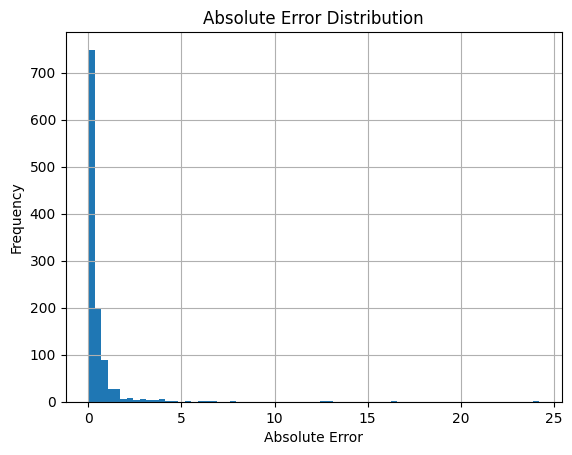


Most important feuteres:
                feature  importance
6            Mean_Score   15.003492
3             Publisher   14.675871
0              Platform   13.688369
2                 Genre   13.585723
5                Rating    9.723389
4             Developer    9.601327
1       Year_of_Release    7.997668
7  Developer_Mean_Score    7.336462
8  Publisher_Mean_Score    4.919288
9   Platform_User_Count    3.468412


In [85]:
y_testCat, y_predCat, cat_model = train(cat_model_df, iterations = 1258, early_stopping_rounds = 150, depth = 10, learning_rate = 0.11151799398085552, l2_leaf_reg = 0.010353766910837621, bagging_temperature = 0.8340499578023164, random_strength = 0.11107743410868681) # See in unit "Hyperparameter optimization"

residCat = y_testCat - y_predCat

ensemble_resid_df['Cat_Fut_resids'] = residCat

 After several attempts to get residuals correlation acceptable for ensembling, by changing model's parameters, loss functions, features, using CatBoost, I've never got correlation less then 0.90, so I decided to change model. First, I will try Random Trees, Extra Random Trees.

In [86]:
def train_tree(model_original, df_original):

    df_full = copy.deepcopy(df_original)
    model = copy.deepcopy(model_original)

    for df in df_full:
        df["Global_Sales"] = np.log1p(df["Global_Sales"])

    df_train_model = pd.concat([df_full[0], df_full[1]]) # Random Forests & Extra Forests don't requers early stopping, so I've decided to merge val and test
    df_test_model = df_full[2]

    X_train = df_train_model.drop(columns=["Name", "Global_Sales"])
    y_train = df_train_model["Global_Sales"]

    X_test = df_test_model.drop(columns=["Name", "Global_Sales"])
    y_test = df_test_model["Global_Sales"]

    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
    encoders = {}

    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    if cat_features:
        for col in cat_features:
            le = LabelEncoder()
            all_values = pd.concat([X_train_encoded[col], X_test_encoded[col]])
            le.fit(all_values.astype(str))

            X_train_encoded[col] = le.transform(X_train_encoded[col].astype(str))
            X_test_encoded[col] = le.transform(X_test_encoded[col].astype(str))

            encoders[col] = le

    model.fit(X_train_encoded, y_train)
    preds = model.predict(X_test_encoded)

    preds = np.expm1(preds)
    y_test_original = np.expm1(y_test)

    r2 = r2_score(y_test_original, preds)
    mse = mean_squared_error(y_test_original, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, preds)

    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    plt.hist(abs(preds - y_test_original), bins=70)
    plt.title("Absolute Error Distribution")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    feature_importance = model.feature_importances_
    feature_names = X_train_encoded.columns
    importance_df = pd.DataFrame({
      'feature': feature_names,
      'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print(f"\nMost important features")
    print(importance_df.head(100))

    return y_test_original, pd.Series(preds), model, encoders

R²: 0.5384
MSE: 1.8905
RMSE: 1.3750
MAE: 0.4563


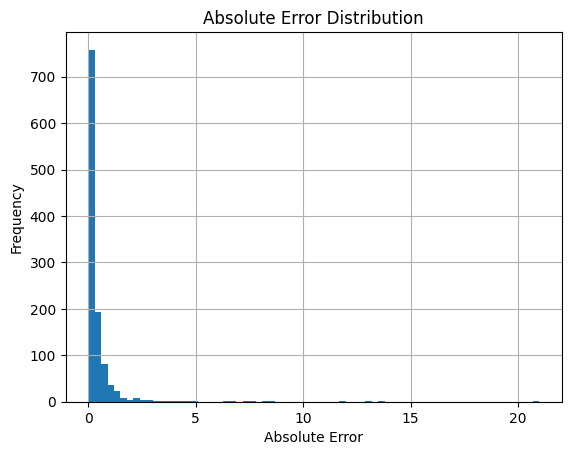


Топ важных признаков
                    feature  importance
7                User_Count    0.214585
5              Critic_Count    0.104405
4              Critic_Score    0.094155
12               Mean_Score    0.085742
15      Platform_User_Count    0.072938
13     Developer_Mean_Score    0.058675
1           Year_of_Release    0.052401
10  Publisher_Release_Count    0.048108
11  Developer_Release_Count    0.046866
0                  Platform    0.045117
6                User_Score    0.038181
14     Publisher_Mean_Score    0.036342
8                 Developer    0.033604
2                     Genre    0.024319
3                 Publisher    0.022752
9                    Rating    0.021811


In [87]:
RF_params = {'n_estimators': 500, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False} # See in unit "Hyperparameter optimization"
RF_tree_model = RandomForestRegressor(**RF_params)

rf_test, rf_preds, rf_model, rf_encoders = train_tree(RF_tree_model, full_df_advanced)

residRF = rf_test - rf_preds

ensemble_resid_df["rf_resid"] = residRF

R²: 0.4907
MSE: 2.0860
RMSE: 1.4443
MAE: 0.4738


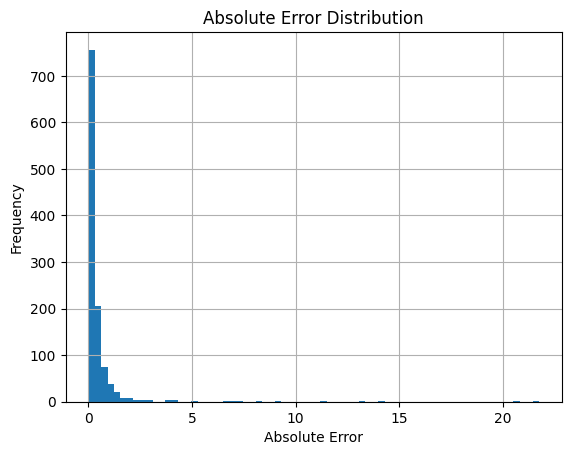


Топ важных признаков
                    feature  importance
7                User_Count    0.164561
5              Critic_Count    0.147016
4              Critic_Score    0.103831
12               Mean_Score    0.088549
15      Platform_User_Count    0.075218
1           Year_of_Release    0.050920
11  Developer_Release_Count    0.048965
10  Publisher_Release_Count    0.048335
0                  Platform    0.047795
13     Developer_Mean_Score    0.038714
14     Publisher_Mean_Score    0.036857
9                    Rating    0.036565
2                     Genre    0.031481
6                User_Score    0.029192
8                 Developer    0.028018
3                 Publisher    0.023982


In [88]:
EF_params = {'n_estimators': 2100, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': False}
EF_model = ExtraTreesRegressor(**EF_params)

ef_test, ef_preds, ef_model, ef_encoders = train_tree(EF_model, full_df_advanced)

residEF = ef_test - ef_preds

ensemble_resid_df["ef_resid"] = residEF

In [89]:
correlation_matrix = ensemble_resid_df.corr()
print("Матрица корреляции остатков моделей:")
print(correlation_matrix)

Матрица корреляции остатков моделей:
                CatBoost_resid  Cat_Fut_resids  rf_resid  ef_resid
CatBoost_resid        1.000000        0.979574  0.988790  0.986279
Cat_Fut_resids        0.979574        1.000000  0.991605  0.992536
rf_resid              0.988790        0.991605  1.000000  0.999272
ef_resid              0.986279        0.992536  0.999272  1.000000


In [90]:
def predict_tree(model, encoders, X):
    X_encoded = X.copy()

    for col, le in encoders.items():
        if col in X_encoded.columns:
            X_encoded[col] = le.transform(X_encoded[col].astype(str))

    preds = model.predict(X_encoded)
    preds = np.expm1(preds)
    return preds

R²: 0.6712
MSE: 1.3467
RMSE: 1.1605
MAE: 0.4149


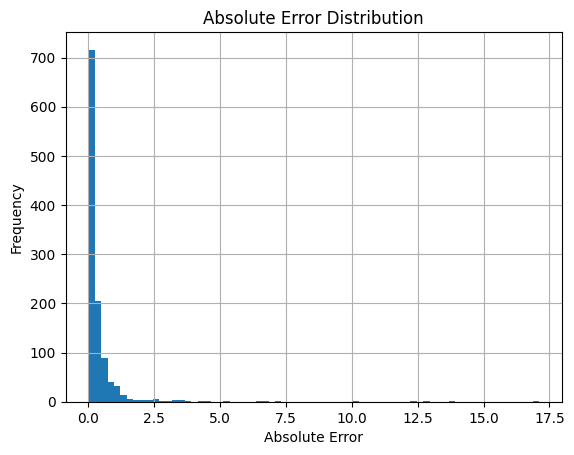

In [91]:
df_ensemble_test = full_df_advanced[2].copy()
x_ensemble_test = df_ensemble_test.drop(columns=["Name", "Global_Sales"])
y_ensemble_test = df_ensemble_test["Global_Sales"]

ensemble_predict = (predict_tree(rf_model, ef_encoders, x_ensemble_test) + np.expm1(main_model.predict(x_ensemble_test)))/2

r2 = r2_score(y_ensemble_test, ensemble_predict)
mse = mean_squared_error(y_ensemble_test, ensemble_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_ensemble_test, ensemble_predict)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

plt.hist(abs(ensemble_predict - y_ensemble_test), bins=70)
plt.title("Absolute Error Distribution")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Comparison with the main model reveals a deterioration in the R², RMSE and MAE metrics\
Differences:\
R²: −0.0703\
RMSE: +0.1312\
MAE: +0.0159

This poor result was quite predictable due to the high correlation of residuals. I've decided to reject this ensemble and will try a different approach.

Since I couldn’t reduce the correlation of residuals, I’ve decided to change the approach.\
I want to try residual models that are trained not to predict the target directly, but to correct the predictions of the main model.

### Residual modeling.

First, the residual model should learn to predict the direction of the error, because even if overall accuracy of the ensemble initially degrades, if residual model can correctly predict direction of the error, it might be possible to correct the final prediction using the transformation function or coefficient.

So i decided to use correctness of direction prediction as one of metric.

Pay attention, main model overfited for _"train"_  split, so it's incorrect and counter effectively to learn residual model on this split. At the same time, without _"train"_ split all we can do, it's train on _"validation"_ split. It's not entirely correct for some reasons, but not forbidden in my opinion.

In [92]:
def residual_model_split_processing(df):
    residual_model_split = df.copy()

    X_train = residual_model_split.drop(columns=["Name", "Global_Sales"])
    y_train = residual_model_split["Global_Sales"]

    log_y_train = np.log1p(y_train)
    log_model_prediction = main_model.predict(X_train)

    residual_model_split["Residuals"] = log_y_train - log_model_prediction

    model_prediction_original = np.expm1(log_model_prediction)
    residual_model_split["Model_Prediction"] = model_prediction_original
    residual_model_split["Squared_prediction"] = model_prediction_original ** 2

    global_distribution = pd.concat([full_df[0], full_df[1]])
    target = global_distribution["Global_Sales"]
    log_target = np.log1p(target)

    mean = np.mean(log_target)
    std = np.std(log_target)
    z_score = (log_model_prediction - mean) / std

    residual_model_split["Z_score"] = z_score
    from scipy.stats import percentileofscore

    residual_model_split["Prediction_Percentile"] = pd.Series(model_prediction_original).apply(
        lambda x: percentileofscore(log_target, x) / 100.0
    ) # VERY STRANGE AND IMPORTANT THING, WORKS AS A CATEGORICAL FEATURE BECAUSE OF NAN ON SMALL VALUES

    return residual_model_split.copy()

In [93]:
residual_model_train = residual_model_split_processing(full_df_advanced[1])

In [94]:
residual_model_test = residual_model_split_processing(full_df_advanced[2])

In [95]:
residual_model_df = [residual_model_train, residual_model_test]

Custom eval metric for tracking model accuracy.\
Checks how often the model predicts the correct direction (positive or negative) of the target. DA $ \in [0, 1]$

In [96]:
def direction_accuracy(y_pred, y_true):

    correct_direction = np.sum(np.sign(y_true) == np.sign(y_pred))
    return correct_direction / len(y_true)

In [97]:
def train_residual_model (model, origin_df):
    selected_features = [

    # Top important features
    'User_Count',
    'Platform',
    'Genre',
    'Year_of_Release',
    'Platform_User_Count',

    # Meta-features
    'Model_Prediction', 'Squared_prediction', 'Z_score', 'Prediction_Percentile',

    # Target
    'Residuals'
    ]

    enhanced_features = [df[selected_features].copy() for df in origin_df]

    df_train_model = enhanced_features[0].copy()
    df_test_model = enhanced_features[1].copy()

    X_train = df_train_model.drop(columns=["Residuals"])
    y_train = df_train_model["Residuals"]

    X_test = df_test_model.drop(columns=["Residuals"])
    y_test = df_test_model["Residuals"]

    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    encoders = {}

    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    if cat_features:
        for col in cat_features:
            le = LabelEncoder()
            all_values = pd.concat([X_train_encoded[col], X_test_encoded[col]])
            le.fit(all_values.astype(str))

            X_train_encoded[col] = le.transform(X_train_encoded[col].astype(str))
            X_test_encoded[col] = le.transform(X_test_encoded[col].astype(str))

            encoders[col] = le

    model.fit(X_train_encoded, y_train)
    preds = model.predict(X_test_encoded)

    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    da = direction_accuracy(preds, y_test)

    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"DA: {da:.4f}")
    plt.hist(abs(preds - y_test), bins=70)
    plt.title("Absolute Error Distribution")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    feature_importance = model.feature_importances_
    feature_names = X_train_encoded.columns
    importance_df = pd.DataFrame({
      'feature': feature_names,
      'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print(f"\nMost important features")
    print(importance_df.head(100))

    return y_test, pd.Series(preds), model, encoders

R²: 0.3390
MSE: 0.0411
RMSE: 0.2027
MAE: 0.1449
DA: 0.6263


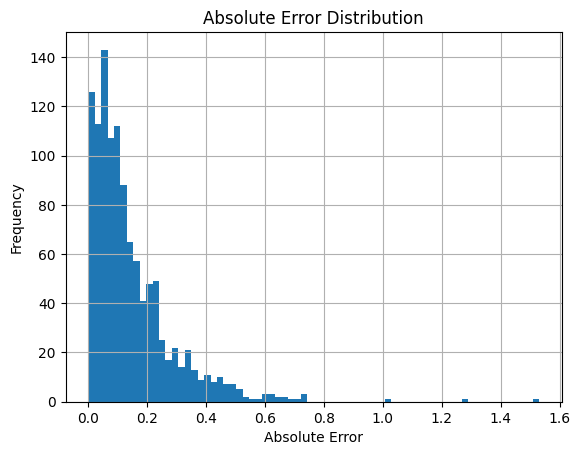


Топ важных признаков
                 feature  importance
6     Squared_prediction    0.491275
8  Prediction_Percentile    0.236564
5       Model_Prediction    0.070885
4    Platform_User_Count    0.046927
0             User_Count    0.042886
2                  Genre    0.038743
1               Platform    0.037245
3        Year_of_Release    0.035474
7                Z_score    0.000000


In [98]:
XGB_parameters = {'objective': 'reg:squarederror', 'n_estimators': 436, 'max_depth': 2, 'learning_rate': 0.176782859117882, 'subsample': 0.6313655451382852, 'colsample_bytree': 0.9564265665295741, 'reg_alpha': 2.9691113293288858, 'reg_lambda': 4.105107139711937, 'min_child_weight': 7}

model = xgb.XGBRegressor(**XGB_parameters)
res_test, res_preds, res_model, res_encoders = train_residual_model(model, residual_model_df)

In [99]:
def predict_residual(model, encoders, X):

    selected_features = [
        # Top important features
        'User_Count',
        'Platform',
        'Genre',
        'Year_of_Release',
        'Platform_User_Count',

        # Meta-features
        'Model_Prediction', 'Squared_prediction', 'Z_score', 'Prediction_Percentile',

    ]

    X_encoded = X[selected_features].copy()

    for col, le in encoders.items():
        if col in X_encoded.columns:
            X_encoded[col] = le.transform(X_encoded[col].astype(str))

    resid = model.predict(X_encoded)
    resid = np.expm1(resid)

    return resid

Weight: 0.10, R²: 0.7501
Weight: 0.15, R²: 0.7548
Weight: 0.20, R²: 0.7594
Weight: 0.25, R²: 0.7638
Weight: 0.30, R²: 0.7681
Weight: 0.35, R²: 0.7722
Weight: 0.40, R²: 0.7761
Weight: 0.45, R²: 0.7799
Weight: 0.50, R²: 0.7834
Weight: 0.55, R²: 0.7867
Weight: 0.60, R²: 0.7897
Weight: 0.65, R²: 0.7926
Weight: 0.70, R²: 0.7951
Weight: 0.75, R²: 0.7974
Weight: 0.80, R²: 0.7994
Weight: 0.85, R²: 0.8010
Weight: 0.90, R²: 0.8023
Weight: 0.95, R²: 0.8033
Weight: 1.00, R²: 0.8039
Weight: 1.05, R²: 0.8040
Weight: 1.10, R²: 0.8038
Weight: 1.15, R²: 0.8030
Weight: 1.20, R²: 0.8018
Weight: 1.25, R²: 0.8000
Weight: 1.30, R²: 0.7977
Weight: 1.35, R²: 0.7947
Weight: 1.40, R²: 0.7912
Weight: 1.45, R²: 0.7869
Weight: 1.50, R²: 0.7819
Weight: 1.55, R²: 0.7760

=== SCIPY OPTIMIZATION ===
 Optimal weight (Scipy): 1.0444
 Optimal R²: 0.8040

Optimized ensemble:
R²: 0.8040
MSE: 0.8026
RMSE: 0.8959
MAE: 0.3525


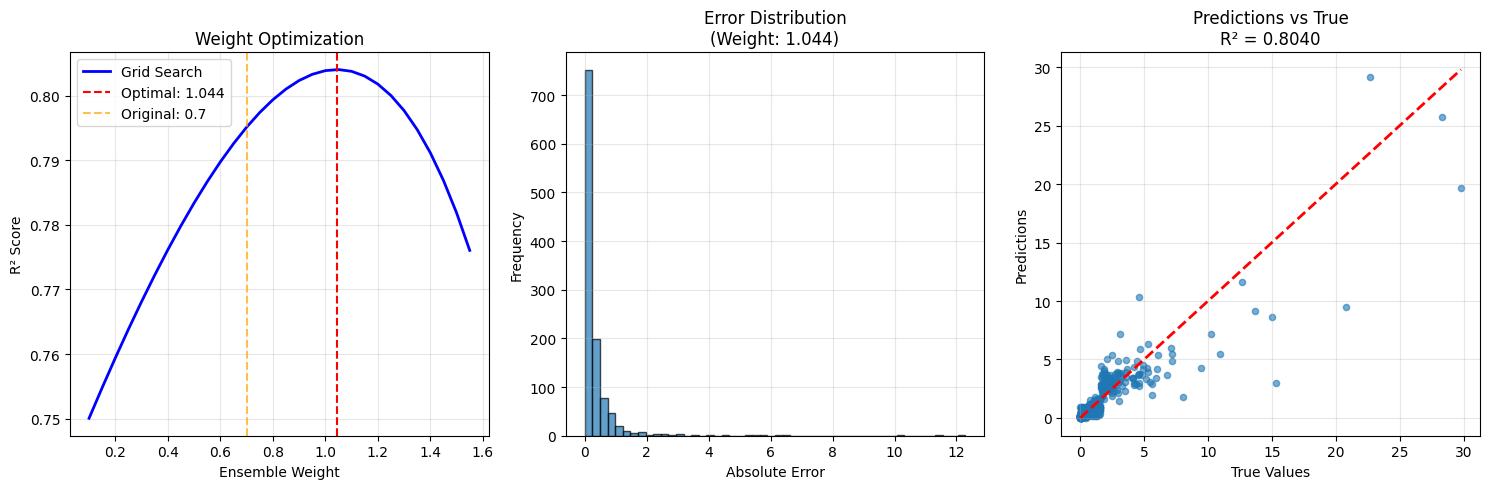

In [100]:
df_ensemble_test = residual_model_df[1].copy()
x_ensemble_test = df_ensemble_test.drop(columns=["Name", "Global_Sales"])
y_ensemble_test = df_ensemble_test["Global_Sales"]

main_predictions = main_model.predict(x_ensemble_test)
residual_predictions = predict_residual(res_model, res_encoders, x_ensemble_test)


def evaluate_weight(weight):
    ensemble_pred = np.expm1(main_predictions + residual_predictions * weight)
    return r2_score(y_ensemble_test, ensemble_pred)

weights = np.arange(0.1, 1.6, 0.05)
scores = []

for w in weights:
    score = evaluate_weight(w)
    scores.append(score)
    print(f"Weight: {w:.2f}, R²: {score:.4f}")

best_idx = np.argmax(scores)
best_weight_grid = weights[best_idx]
best_score_grid = scores[best_idx]

print("\n=== SCIPY OPTIMIZATION ===")

def objective_function(weight):
    ensemble_pred = np.expm1(main_predictions + residual_predictions * weight)
    r2 = r2_score(y_ensemble_test, ensemble_pred)
    return -r2

result = minimize_scalar(
    objective_function,
    bounds=(0.1, 2.0),
    method='bounded',
    options={'xatol': 1e-4}
)

optimal_weight = result.x
optimal_score = -result.fun

print(f" Optimal weight (Scipy): {optimal_weight:.4f}")
print(f" Optimal R²: {optimal_score:.4f}")

ensemble_predict = np.expm1(main_predictions + residual_predictions * optimal_weight)

r2 = r2_score(y_ensemble_test, ensemble_predict)
mse = mean_squared_error(y_ensemble_test, ensemble_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_ensemble_test, ensemble_predict)

print(f"\nOptimized ensemble:")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")



plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(weights, scores, 'b-', linewidth=2, label='Grid Search')
plt.axvline(optimal_weight, color='red', linestyle='--', label=f'Optimal: {optimal_weight:.3f}')
plt.axvline(0.7, color='orange', linestyle='--', alpha=0.7, label='Original: 0.7')
plt.xlabel('Ensemble Weight')
plt.ylabel('R² Score')
plt.title('Weight Optimization')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
errors = abs(ensemble_predict - y_ensemble_test)
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title(f'Error Distribution\n(Weight: {optimal_weight:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(y_ensemble_test, ensemble_predict, alpha=0.6, s=20)
plt.plot([y_ensemble_test.min(), y_ensemble_test.max()],
         [y_ensemble_test.min(), y_ensemble_test.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True\nR² = {r2:.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

R²: 0.8040
MSE: 0.8026
RMSE: 0.8959
MAE: 0.3525


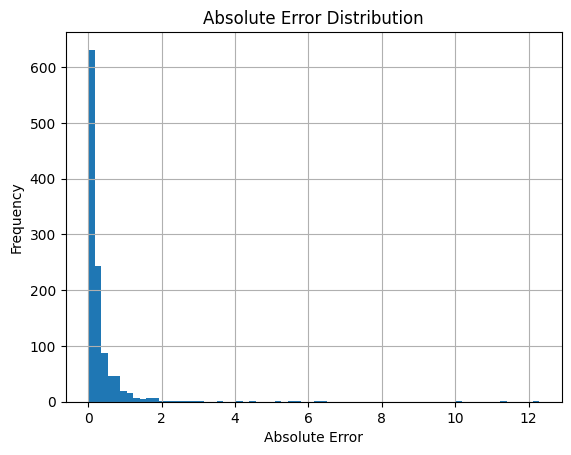


Metric difference (ensemble - main):
Δ R²:   +0.0639
Δ MSE:  -0.2616
Δ RMSE: -0.1357
Δ MAE:  -0.0470

Relative change in metrics (in percent)):
% Δ R²:     +8.63%
% Δ MSE:   -24.58%
% Δ RMSE:  -13.16%
% Δ MAE:   -11.78%


In [101]:
df_ensemble_test = residual_model_df[1].copy()
x_ensemble_test = df_ensemble_test.drop(columns=["Name", "Global_Sales"])
y_ensemble_test = df_ensemble_test["Global_Sales"]

ensemble_predict =  np.expm1(main_model.predict(x_ensemble_test) + predict_residual(res_model, res_encoders, x_ensemble_test) * optimal_weight)

r2 = r2_score(y_ensemble_test, ensemble_predict)
mse = mean_squared_error(y_ensemble_test, ensemble_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_ensemble_test, ensemble_predict)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

plt.hist(abs(ensemble_predict - y_ensemble_test), bins=70)
plt.title("Absolute Error Distribution")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

r2_main, mse_main, rmse_main, mae_main = main_model_metrics

print("\nMetric difference (ensemble - main):")
print(f"Δ R²:   {r2 - r2_main:+.4f}")
print(f"Δ MSE:  {mse - mse_main:+.4f}")
print(f"Δ RMSE: {rmse - rmse_main:+.4f}")
print(f"Δ MAE:  {mae - mae_main:+.4f}")

print("\nRelative change in metrics (in percent)):")
def pct_change(new, old):
    try:
        return 100 * (new - old) / abs(old) if abs(old) > 1e-8 else float('nan')
    except ZeroDivisionError:
        return float('nan')

print(f"% Δ R²:   {pct_change(r2, r2_main):+7.2f}%")
print(f"% Δ MSE:  {pct_change(mse, mse_main):+7.2f}%")
print(f"% Δ RMSE: {pct_change(rmse, rmse_main):+7.2f}%")
print(f"% Δ MAE:  {pct_change(mae, mae_main):+7.2f}%")


## _Conclusion & additions_
---

### Final Results
- **Best Model**: CatBoost + XGBoost Residual Ensemble
- **Final R²**: 0.8040 (+8.63% improvement)
- **Key Innovation**: Residual correction methodology

### Work done

Looking for effective approach for ensembling many options were tried, not included in final version, but are worthy of mention.\
Was done:
- Research of residual correlations for different models:
- - Deep and not deep models.
- - Models with different loss functions MAE/RMSE.
All had high residuals correlations, so were rejected.
- I've tried to make custom loss function, since residual modelling is asymmetrical task, but suddenly thats more difficult than I expected, and not fit with topic's goal.
- A lot of mistakes were made.

### Hyperparameter optimization

This unit contains code of _Optuna_ optimization framework for all models. Count of trials I've set to 1, because optimization very hard task with execution time reaches up to some hour(depends on number of trials and models). Also look at the code, I minimized some parameters.

In [102]:
def objective(trial, df_original):

    df_full = copy.deepcopy(df_original)

    for df in df_full[:2]:
        df["Global_Sales"] = np.log1p(df["Global_Sales"])

    df_train_model = df_full[0]
    df_val_model = df_full[1]
    df_test_model = df_full[2]

    X_train = df_train_model.drop(columns=["Name", "Global_Sales"])
    y_train = df_train_model["Global_Sales"]

    X_val = df_val_model.drop(columns=["Name", "Global_Sales"])
    y_val = df_val_model["Global_Sales"]

    X_test = df_test_model.drop(columns=["Name", "Global_Sales"])
    y_test = df_test_model["Global_Sales"]

    cat_features = X_train.select_dtypes(include = object).columns.tolist()
    max_iters = trial.suggest_int("iterations", 300, 1000) # Set 700 - 5000
    params = {
        'iterations': max_iters,
        'depth': trial.suggest_int('depth', 3, 6), # set 8 - 11
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 3, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'cat_features': cat_features,
        'early_stopping_rounds': int(0.1 * max_iters)+50,
        'verbose': 0,
        'random_seed': 42,

        'posterior_sampling': True,
        'rsm': trial.suggest_float('rsm', 0.6, 1.0),
    }

    model = CatBoostRegressor(**params)

    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    raw_preds = model.predict(X_test)
    preds = np.expm1(raw_preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    return rmse

In [103]:
obj_fn = partial(objective, df_original = full_df_advanced)

study = optuna.create_study(direction="minimize")
study.optimize(obj_fn, n_trials= 2) # Set 30

print("Best trial:")
print(study.best_trial.params)

[I 2025-08-06 14:36:46,073] A new study created in memory with name: no-name-76f10d81-427c-4a2d-944d-b2529c404c09
[I 2025-08-06 14:37:04,250] Trial 0 finished with value: 1.3888959373369951 and parameters: {'iterations': 362, 'depth': 6, 'learning_rate': 0.014101173955369927, 'l2_leaf_reg': 1.0949982739377613, 'bagging_temperature': 0.23694226951564235, 'random_strength': 0.21734422426990666, 'rsm': 0.7693123561930143}. Best is trial 0 with value: 1.3888959373369951.
[I 2025-08-06 14:37:49,482] Trial 1 finished with value: 1.1111788234455826 and parameters: {'iterations': 864, 'depth': 6, 'learning_rate': 0.01753464357671333, 'l2_leaf_reg': 0.010898672864070572, 'bagging_temperature': 0.29079392420788186, 'random_strength': 0.14619940159521475, 'rsm': 0.9362757050703845}. Best is trial 1 with value: 1.1111788234455826.


Best trial:
{'iterations': 864, 'depth': 6, 'learning_rate': 0.01753464357671333, 'l2_leaf_reg': 0.010898672864070572, 'bagging_temperature': 0.29079392420788186, 'random_strength': 0.14619940159521475, 'rsm': 0.9362757050703845}


In [104]:
plot_optimization_history(study).show()
plot_param_importances(study).show()
plot_slice(study).show()
plot_parallel_coordinate(study).show()

In [105]:
def objective_RF(trial, df_original):
    df_full = copy.deepcopy(df_original)

    df_train_model = pd.concat([df_full[0], df_full[
        1]])  # Random Forests & Extra Forests don't requers early stopping, so I've decided to merge val and test
    df_test_model = df_full[2]

    X_train = df_train_model.drop(columns=["Name", "Global_Sales"])
    y_train = df_train_model["Global_Sales"]

    X_test = df_test_model.drop(columns=["Name", "Global_Sales"])
    y_test = df_test_model["Global_Sales"]

    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    if cat_features:
        for col in cat_features:
            le = LabelEncoder()
            all_values = pd.concat([X_train[col], X_test[col]])
            le.fit(all_values.astype(str))

            X_train[col] = le.transform(X_train[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7, 0.9]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    if params['bootstrap']:
        params['max_samples'] = trial.suggest_float('max_samples', 0.5, 1.0)

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    return rmse

In [106]:
def objective_EF(trial, df_original):
    df_full = copy.deepcopy(df_original)

    df_train_model = pd.concat([df_full[0], df_full[1]])
    df_test_model = df_full[2]

    X_train = df_train_model.drop(columns=["Name", "Global_Sales"])
    y_train = df_train_model["Global_Sales"]

    X_test = df_test_model.drop(columns=["Name", "Global_Sales"])
    y_test = df_test_model["Global_Sales"]

    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    if cat_features:
        for col in cat_features:
            le = LabelEncoder()
            all_values = pd.concat([X_train[col], X_test[col]])
            le.fit(all_values.astype(str))

            X_train[col] = le.transform(X_train[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 2500, step=100),
        'max_depth': trial.suggest_int('max_depth', 8, 35),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.2, 0.3, 0.5, 0.7]),
        'bootstrap': trial.suggest_categorical('bootstrap', [False, True]),
        'random_state': 42,
        'n_jobs': -1
    }

    if params['bootstrap']:
        params['max_samples'] = trial.suggest_float('max_samples', 0.5, 1.0)

    model = ExtraTreesRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    return rmse

In [107]:
obj_fn = partial(objective_RF, df_original = full_df_advanced)

study_rf = optuna.create_study(direction="minimize", study_name='RandomForest_Optimization')
study_rf.optimize(obj_fn, n_trials= 1) # Set 50

print("Best trial:")
print(study_rf.best_trial.params)

[I 2025-08-06 14:37:50,577] A new study created in memory with name: RandomForest_Optimization
[I 2025-08-06 14:37:52,581] Trial 0 finished with value: 1.4922294007467374 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 0.3, 'bootstrap': False}. Best is trial 0 with value: 1.4922294007467374.


Best trial:
{'n_estimators': 1300, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 0.3, 'bootstrap': False}


In [108]:
obj_fn = partial(objective_EF, df_original = full_df_advanced)

study_ef = optuna.create_study(direction="minimize", study_name='ExtraForest_Optimization')
study_ef.optimize(obj_fn, n_trials= 1) # Set 50

print("Best trial:")
print(study_ef.best_trial.params)

[I 2025-08-06 14:37:52,605] A new study created in memory with name: ExtraForest_Optimization
[I 2025-08-06 14:37:53,891] Trial 0 finished with value: 1.6819093970119527 and parameters: {'n_estimators': 600, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.2, 'bootstrap': True, 'max_samples': 0.7618552347511236}. Best is trial 0 with value: 1.6819093970119527.


Best trial:
{'n_estimators': 600, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.2, 'bootstrap': True, 'max_samples': 0.7618552347511236}


In [109]:
def objective_RM(trial, origin_df):
    selected_features = [

        # Top important features
        'User_Count',
        'Platform',
        'Genre',
        'Year_of_Release',
        'Platform_User_Count',

        # Meta-features
        'Model_Prediction', 'Squared_prediction', 'Z_score', 'Prediction_Percentile',

        # Target
        'Residuals'
    ]

    enhanced_features = [df[selected_features].copy() for df in origin_df]

    df_train_model = enhanced_features[0].copy()
    df_test_model = enhanced_features[1].copy()

    X_train = df_train_model.drop(columns=["Residuals"])
    y_train = df_train_model["Residuals"]

    X_test = df_test_model.drop(columns=["Residuals"])
    y_test = df_test_model["Residuals"]

    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    if cat_features:
        for col in cat_features:
            le = LabelEncoder()
            all_values = pd.concat([X_train[col], X_test[col]])
            le.fit(all_values.astype(str))

            X_train[col] = le.transform(X_train[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))

    loss_choice = trial.suggest_categorical("loss", ["mae", "mse"])
    if loss_choice == "mae":
        objective = "reg:absoluteerror"
    else:
        objective = "reg:squarederror"
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': objective,
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    return rmse

In [110]:
study = optuna.create_study(direction='minimize')

study.optimize(lambda trial: objective_RM(trial, origin_df=residual_model_df), n_trials=1) # Set 250

[I 2025-08-06 14:37:54,369] A new study created in memory with name: no-name-c0c4a34c-b108-43db-8a57-593c46e84b19
[I 2025-08-06 14:37:54,656] Trial 0 finished with value: 0.2082861346299132 and parameters: {'loss': 'mae', 'n_estimators': 236, 'max_depth': 8, 'learning_rate': 0.0203789868428868, 'subsample': 0.7041599687710813, 'colsample_bytree': 0.7001614667187733, 'reg_alpha': 6.515061540235244, 'reg_lambda': 0.585524061147219, 'min_child_weight': 5}. Best is trial 0 with value: 0.2082861346299132.


In [111]:
#### Optimization archive
# Main model
#{'iterations': 4606, 'depth': 9, 'learning_rate': 0.06657010579964637, 'l2_leaf_reg': 1.0489107047302053, 'bagging_temperature': 0.07852150947288883, 'random_strength': 0.036057785785986646, 'rsm': 0.812826754080271}
# Optimized parameters for non-log target (R2 = 0.67)
#{'iterations': 4502, 'depth': 9, 'learning_rate': 0.05655092655299971, 'l2_leaf_reg': 0.20720063689314963, 'bagging_temperature': 0.2957483841973214, 'random_strength': 0.1575990871426289, 'rsm': 0.9545478304595558}
# Optimized parameters for log target
#{'iterations': 3916, 'depth': 8, 'learning_rate': 0.01651871359633916, 'l2_leaf_reg': 0.8416781669667702, 'bagging_temperature': 0.921976724800867, 'random_strength': 0.30716189050134707, 'rsm': 0.8402469171015531}
#0.74
#iterations = 3916, early_stopping_rounds= int(3916*0.1+50), posterior_sampling=True, rsm = 0.8402469171015531, task_type = "CPU", depth = 8, l2_leaf_reg =  0.8416781669667702, learning_rate = 0.01651871359633916, bagging_temperature = 0.921976724800867,  random_strength = 0.30716189050134707)

# Residual model
    #{'objective': 'reg:absoluteerror', 'n_estimators': 127, 'max_depth': 6, 'learning_rate': 0.06564633425905439, 'subsample': 0.8769926791780822, 'colsample_bytree': 0.8845758372037356, 'reg_alpha': 2.8842657393540563, 'reg_lambda': 6.573616179427852, 'min_child_weight': 2}
    #{'objective': 'reg:squarederror', 'n_estimators': 350, 'max_depth': 2, 'learning_rate': 0.14605401918661187, 'subsample': 0.6255178340438093, 'colsample_bytree': 0.8796077731536921, 'reg_alpha': 2.9787854216762537, 'reg_lambda': 5.089561375384223, 'min_child_weight': 2}
    #{'objective': 'reg:squarederror', 'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.011980065792231443, 'subsample': 0.7253956550922979, 'colsample_bytree': 0.9198316530234281, 'reg_alpha': 0.6881066458642314, 'reg_lambda': 8.925581604064632, 'min_child_weight': 7}
    #{'objective': 'reg:absoluteerror', 'n_estimators': 127, 'max_depth': 6, 'learning_rate': 0.06564633425905439, 'subsample': 0.8769926791780822, 'colsample_bytree': 0.8845758372037356, 'reg_alpha': 2.8842657393540563, 'reg_lambda': 6.573616179427852, 'min_child_weight': 2}

### Insight

This asymmetric metric might be useful, but I don't have time to finish it and test it.

In [112]:
def directional_penalty_obj(y_pred, y_true_data, alpha=2.0):

    y_true = y_true_data.get_label()
    alpha = 2.0
    k = 10.0


    grad_mae = np.sign(y_pred - y_true)


    grad_penalty = -alpha * np.tanh(k * y_true) * (k * (1 - np.tanh(k * y_pred) ** 2))

    grad = grad_mae + grad_penalty


    hess_base = np.ones_like(y_true)


    hess_penalty = -alpha * np.tanh(k * y_true) * \
                   (-2 * k ** 2 * np.tanh(k * y_pred) * (1 - np.tanh(k * y_pred) ** 2))

    hess = hess_base + hess_penalty

    hess = np.maximum(hess, 1e-6)